<a id='home'></a>

# Performance Analysis of VersionedHDF5 Files

For these tests, we have generated `.h5` data files using the `generate_data_deterministic.py` script from the [VersionedHDF5 repository](https://github.com/Quansight/versioned-hdf5), using the standard options ([see details here](#standard))

We performed the following tests:
1. [Test Large Fraction Changes Sparse](#test1)
2. [Test Mostly Appends Sparse](#test2)
3. [Test Small Fraction Changes Sparse](#test3)
4. [Test Mostly Appends Dense](#test4)
5. [Test Large Fraction Changes (Constant Array Size) Sparse](#test5)

**These tests were last run on**

In [1]:
from datetime import datetime
print(datetime.utcnow(), "UTC")

2020-04-30 12:57:13.810702 UTC


## Setup

The path to the generated test files is

In [2]:
path = "/home/melissa/projects/versioned-hdf5/analysis" # change this as necessary

In [3]:
%matplotlib inline
import h5py
import json
import numpy as np
import performance_tests
import matplotlib.pyplot as plt

The information from the generated test files are stored in either
- `testcase.tests`, a dictionary containing all the info related to a testcase that was run recently;
- a `.json` file named after the test name and options, containing a summary of the results. This file can be read with
    ```python
    with open("<filename>.json", "r") as json_in:
        test = json.load(json_in)
    ```

<a id='test1'></a>

# Test 1: Large fraction changes (sparse)

In [4]:
testname = "test_large_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_1 = [50, 100, 500, 1000, 5000, 10000]
```

### Generating new tests 

If you want to generate the files now, modify the following constants for the desired tests. **Please keep in mind that file sizes can become very large for large numbers of transactions (above 5000 transactions).**

In [ ]:
num_transactions_1 = [50, 100]

For the chunk size parameter, we have tested chunk sizes of $2^8, 2^{10}, 2^{12}$ and $2^{14}$.

In [ ]:
exponents_1 = [12, 14]

Choose desired compression algorithm.

In [ ]:
compression_1 = [None, "gzip", "lzf"]

Create files:

In [ ]:
testcase = performance_tests.test_large_fraction_changes_sparse(path=path,
                                                                num_transactions=num_transactions_1, 
                                                                exponents=exponents_1, 
                                                                compression=compression_1)
testcase_1, msg = testcase.create_files()
if msg:
    print(msg)

For later comparison, if you wish to generate the same tests with **no versioning**, meaning no use of the `VersionedHDF5` library, you can use the following command:

In [ ]:
testcase_1_no_versions, msg = testcase.create_files(versions=False)
if msg:
    print(msg)

If you wish to save the results for later, execute the cell below. **CAUTION: This may erase previous versions of saved tests.**

In [ ]:
testcase.save(testcase_1, f"{testname}")
testcase.save(testcase_1_no_versions, f"{testname}_no_versions")

### Reading previously computed tests

If you prefer, you can read an existing `.json` file by uncommenting the lines below.

In [5]:
with open(f"{testname}.json", "r") as json_in:
    testcase_1 = json.load(json_in)
with open(f"{testname}_no_versions.json", "r") as json_in:
    testcase_1_no_versions = json.load(json_in)

## Analysis

First, let's obtain some common parameters from the tests:

In [6]:
num_transactions = [test['num_transactions'] for test in testcase_1]
chunk_sizes = [test['chunk_size'] for test in testcase_1]
compression = [test['compression'] for test in testcase_1]
filesizes = np.array([test['size'] for test in testcase_1])
sizelabels = np.array([test['size_label'] for test in testcase_1])

n = len(set(num_transactions))
ncs = len(set(chunk_sizes))
ncomp = len(set(compression))

We'll start by analyzing how the `.h5` file sizes grow as the number of versions grows. 

Note that the array size also grows as the number of versions grows, since each transaction is changing the original arrays by adding, deleting and changing values in the original arrays. In order to compute a (naive) theoretical lower bound on the file size, we'll compute how much space each version should take. Keep in mind there is redundant data as some of it is not changed during the staging of a new version but it is still being stored. In this example, we start with three arrays with 5000 elements (2 integer arrays and one float), and in the end we have the following array sizes:

```
Maximum array size for file with 50 transactions: 5500
Maximum array size for file with 100 transactions: 6000
Maximum array size for file with 500 transactions: 10000
Maximum array size for file with 1000 transactions: 15000
Maximum array size for file with 5000 transactions: 55000
Maximum array size for file with 10000 transactions: 105000
```

Let's show the size information in a plot. On the left, we can see a linear plot, and on the right a loglog plot of the same size data for `testcase_1`.

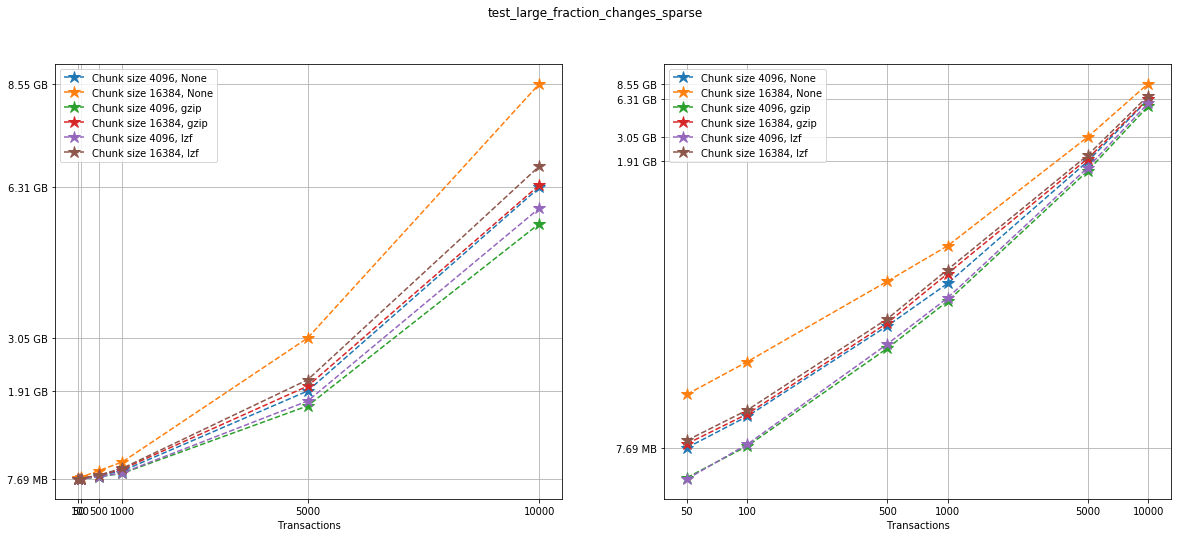

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# Changing the indices in selected will change the y-axis ticks in the graph for better visualization
#selected = (range(len(filesizes)))
selected = [0, 4, 5, 10, 11]

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[0].plot(num_transactions[:n],
                   filesizes[start+j*n:start+(j+1)*n],
                   '*--', ms=12, 
                   label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")

        ax[1].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')
        ax[0].minorticks_off()
        ax[1].minorticks_off()
        ax[0].set_xticks(num_transactions[:n])
        ax[0].set_xticklabels(num_transactions[:n])
        ax[0].set_yticks(filesizes[selected])
        ax[0].set_yticklabels(sizelabels[selected])
        ax[0].set_xlabel("Transactions")
        ax[0].grid(True)
        ax[1].set_xticks(num_transactions[:n])
        ax[1].set_xticklabels(num_transactions[:n])
        ax[1].set_yticks(filesizes[selected])
        ax[1].set_yticklabels(sizelabels[selected])
        ax[1].set_xlabel("Transactions")
        ax[1].grid(True)

plt.suptitle(f"{testname}")
plt.show()

### Comparing compression algorithms

For each chunk size that we chose to test, let's compare the file sizes corresponding to each compression algorithm that we used.

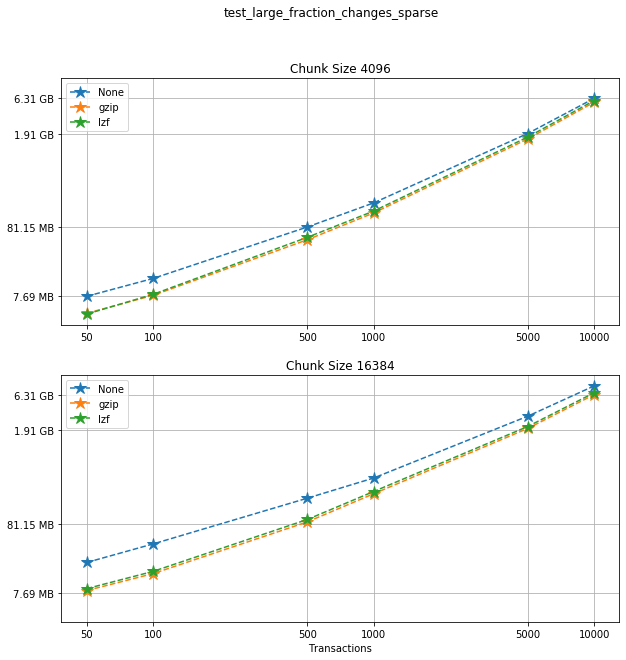

In [22]:
fig, ax = plt.subplots(ncs, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")

selected = [0, 2, 4, 5]
    
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[j].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=f"{compression[start]}")
        ax[j].legend(loc='upper left')
        ax[j].set_title(f"Chunk Size {chunk_sizes[start+j*n]}")
        ax[j].set_xticks(num_transactions[:n])
        ax[j].set_xticklabels(num_transactions[:n])
        ax[j].set_yticks(filesizes[selected])
        ax[j].set_yticklabels(sizelabels[selected])
        ax[j].grid(True)
        ax[j].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

### Comparing chunk sizes

Now, for each choice of compression algorithm, we compare different chunk sizes.

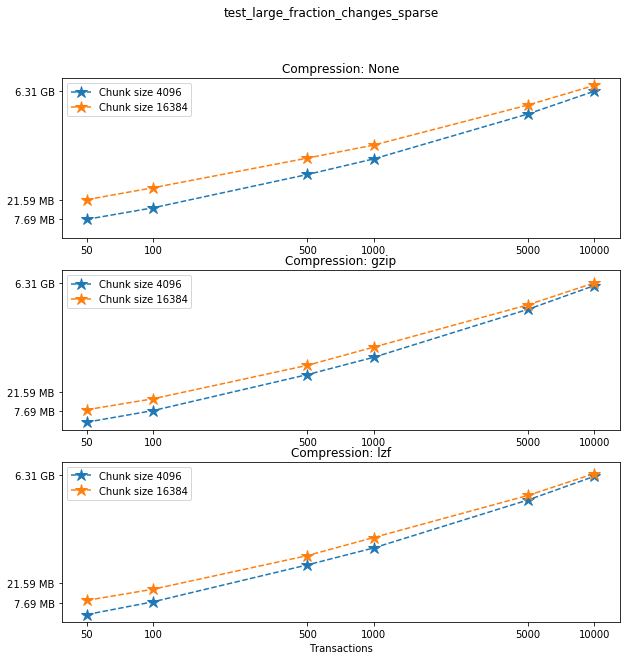

In [27]:
fig, ax = plt.subplots(ncomp, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")
    
selected = [0, 5, 6]
    
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plotlabel = f"Chunk size {chunk_sizes[start+j*n]}"
        plottitle = f"Compression: {compression[start]}"
        ax[i].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=plotlabel)
        ax[i].legend(loc='upper left')
        ax[i].set_title(plottitle)
        ax[i].set_xticks(num_transactions[:n])
        ax[i].set_xticklabels(num_transactions[:n])
        ax[i].set_yticks(filesizes[selected])
        ax[i].set_yticklabels(sizelabels[selected])
        ax[i].grid(False)
        ax[i].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

## Creation times

If we look at the creation times for these files, we have something like this:

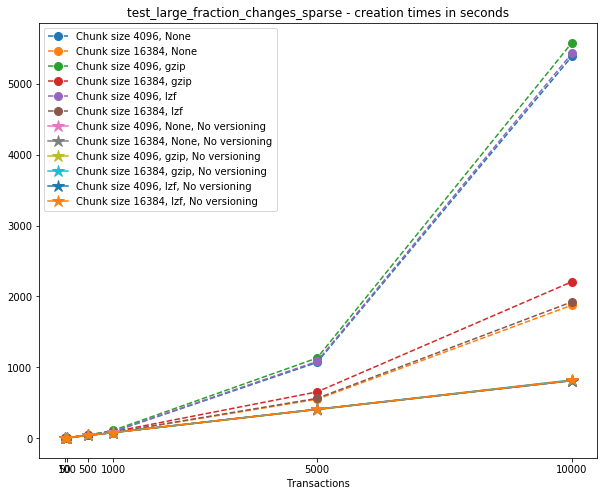

In [28]:
t_write = np.array([test['t_write'][-1] for test in testcase_1])
fig_large_fraction_changes_times = plt.figure(figsize=(10,8))
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write[start+j*n:start+(j+1)*n], 
                 'o--', ms=8, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")

# If you also with to plot information about the "no versions" test,  
# run the following lines:
t_write_nv = np.array([test['t_write'][-1] for test in testcase_1_no_versions])
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write_nv[start+j*n:start+(j+1)*n], 
                 '*-', ms=12, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}, No versioning")

plt.xlabel("Transactions")
plt.title(f"{testname} - creation times in seconds")
plt.legend()
plt.xticks(num_transactions[:n])
plt.show()

Now, we can look at the time required to stage a new version in the file, that is, to add a new transaction. The graphs below show, for each fixed number of transactions, the time required to add new versions as the file is created.

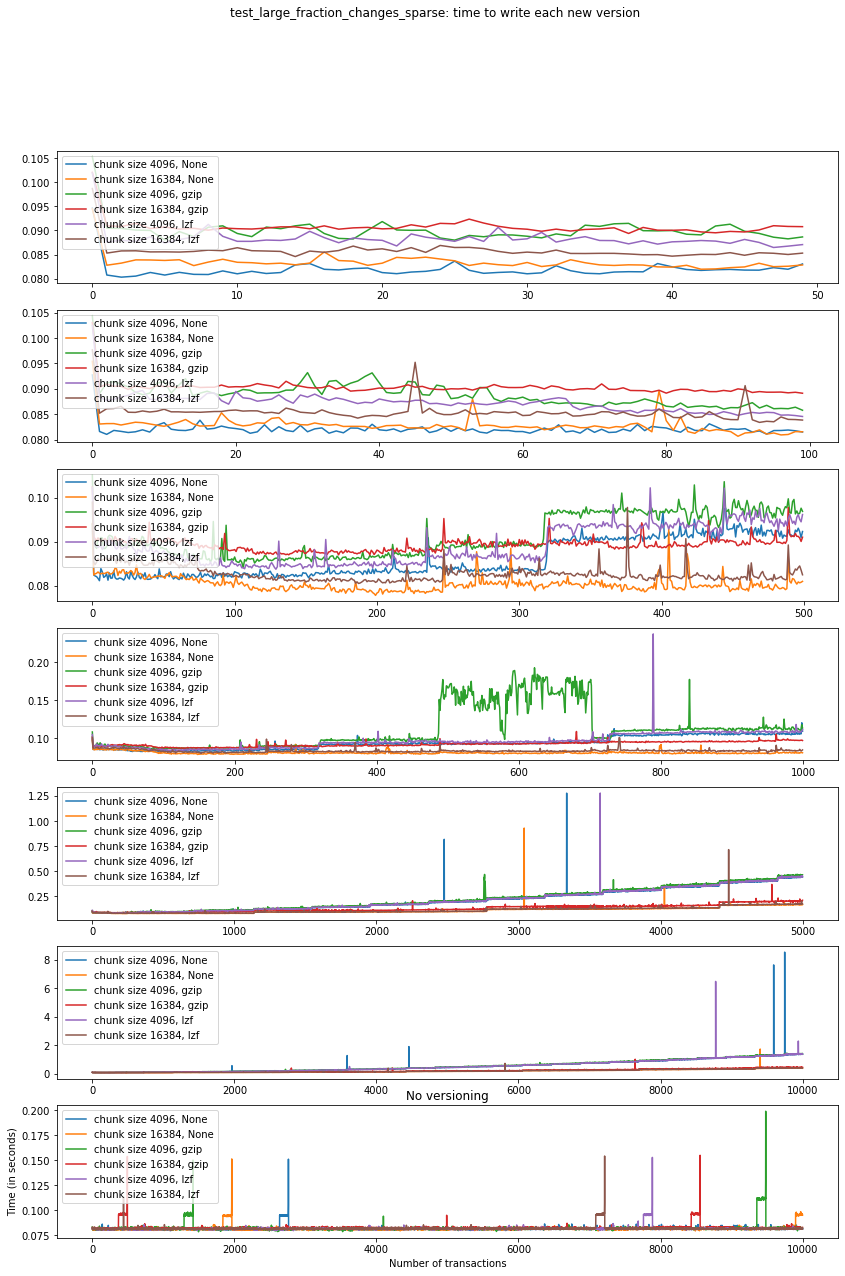

In [29]:
fig_times, ax = plt.subplots(n+1, figsize=(14,20))
fig_times.suptitle(f"{testname}: time to write each new version")

for i in range(n):
    for test in testcase_1:
        if test['num_transactions'] == num_transactions[i]:
            t_write = np.array(test['t_write'][:-1])
            ax[i].plot(t_write, 
                       label=f"chunk size {test['chunk_size']}, {test['compression']}")
            ax[i].legend(loc='upper left')

# If you also with to plot information about the "no versions" test,  
# run the following lines:
for test in testcase_1_no_versions:
    if test['num_transactions'] == num_transactions[i]:
        t_write = np.array(test['t_write'][:-1])
        ax[n].plot(t_write, 
                   label=f"chunk size {test['chunk_size']}, {test['compression']}")
        ax[n].legend(loc='upper left')
        ax[n].set_title('No versioning')
            
plt.xlabel("Number of transactions")
plt.ylabel("Time (in seconds)")
plt.show()

## Summary

We can clearly see that files with smallest file size, corresponding to smaller chunk sizes, are also the ones with largest creation times. **This is consistent with the effects of using smaller chunk sizes in HDF5 files.**

This behaviour suggests that for `test_large_fraction_changes_sparse`, larger chunk sizes generate larger files, but the size of the files grows modestly as the number of transactions grow. So, **if we are dealing with a large number of transactions, larger chunk sizes generate files that are of reasonable size while having faster creation times** (and probably faster IO speeds as well).

[Back to top](#home)

<a id='test2'></a>

# Test 2: Mostly appends (sparse)

In [30]:
testname = "test_mostly_appends_sparse"

For this case, we have tested the following number of transactions:

```python
num_transactions_2 = [50, 100, 200]
```

### Generating new tests

Change `num_transactions_2`, `exponents_2` and `compression_2` as desired (the previous warning applies: beware of very large file sizes and creation times for large numbers of versions):

In [31]:
num_transactions_2 = [25, 50, 100, 200]
exponents_2 = [12, 14]
compression_2 = [None, "gzip", "lzf"]

Create files:

In [32]:
testcase = performance_tests.test_mostly_appends_sparse(path=path,
                                                        num_transactions=num_transactions_2, 
                                                        exponents=exponents_2, 
                                                        compression=compression_2)
testcase_2, msg = testcase.create_files()
if msg:
    print(msg)

File with 25 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 50 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 100 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 200 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 25 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 50 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 100 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 200 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 25 transactions, chunk size 2**12 and compression filter gzip not available. Creating new file.
File with 50 transactions, chunk size 2**1

For later comparison, if you wish to generate the same tests with **no versioning**, meaning no use of the `VersionedHDF5` library, you can use the following command:

In [33]:
testcase_2_no_versions, msg = testcase.create_files(versions=False)
if msg:
    print(msg)

File with 25 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 50 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 100 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 200 transactions, chunk size 2**12 and compression filter None not available. Creating new file.
File with 25 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 50 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 100 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 200 transactions, chunk size 2**14 and compression filter None not available. Creating new file.
File with 25 transactions, chunk size 2**12 and compression filter gzip not available. Creating new file.
File with 50 transactions, chunk size 2**1

If you wish to save the results for later, execute the cell below:

In [34]:
testcase.save(testcase_2, f"{testname}")
testcase.save(testcase_2_no_versions, f"{testname}_no_versions")

### Reading previously computed tests

To read an existing `.json` file, uncomment the lines below.

In [35]:
with open(f"{testname}.json", "r") as json_in:
    testcase_2 = json.load(json_in)
with open(f"{testname}_no_versions.json", "r") as json_in:
    testcase_2_no_versions = json.load(json_in)

## Analysis

Repeating the same analysis as in the previous test, let's show the size information in a graph:

In [36]:
num_transactions = [test['num_transactions'] for test in testcase_2]
chunk_sizes = [test['chunk_size'] for test in testcase_2]
compression = [test['compression'] for test in testcase_2]
filesizes = np.array([test['size'] for test in testcase_2])
sizelabels = np.array([test['size_label'] for test in testcase_2])

n = len(set(num_transactions))
ncs = len(set(chunk_sizes))
ncomp = len(set(compression))

Similarly to what we did before, on the left we can see a linear plot, and on the right a loglog plot of the same size data for `testcase_2`.

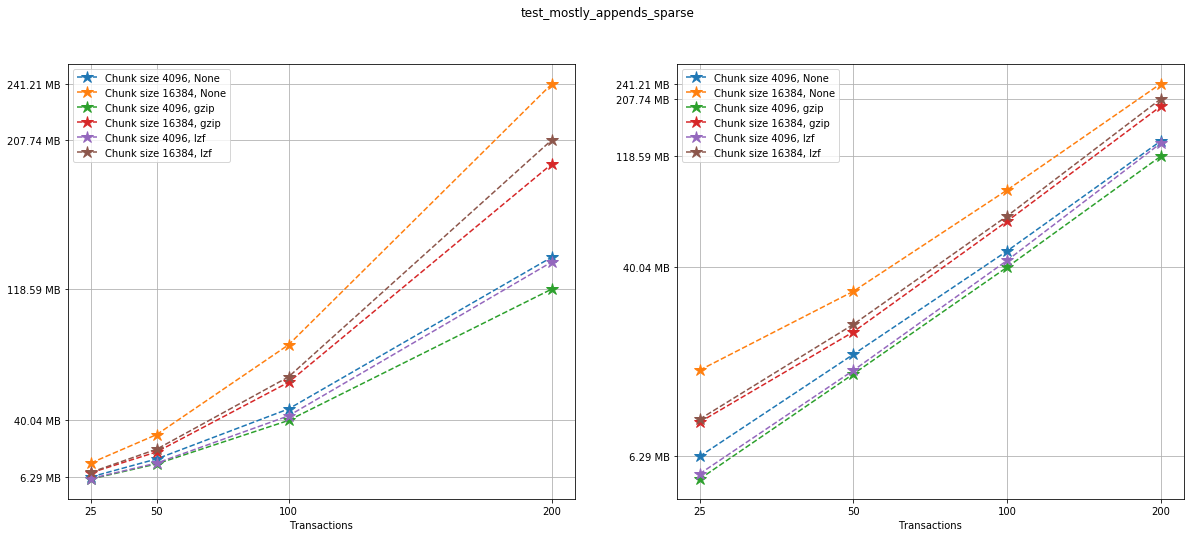

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

selected = [0, 7, 10, 11, 23]

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[0].plot(num_transactions[:n],
                   filesizes[start+j*n:start+(j+1)*n], 
                   '*--', ms=12, 
                   label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[1].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n], 
                     '*--', ms=12, 
                     label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')
        ax[0].minorticks_off()
        ax[1].minorticks_off()
        # Changing the indices in selected will change the y-axis ticks in the graph for better visualization
        ax[0].set_xticks(num_transactions[:n])
        ax[0].set_xticklabels(num_transactions[:n])
        ax[0].set_yticks(filesizes[selected])
        ax[0].set_yticklabels(sizelabels[selected])
        ax[0].set_xlabel("Transactions")
        ax[0].grid(True)
        ax[1].set_xticks(num_transactions[:n])
        ax[1].set_xticklabels(num_transactions[:n])
        ax[1].set_yticks(filesizes[selected])
        ax[1].set_yticklabels(sizelabels[selected])
        ax[1].set_xlabel("Transactions")
        ax[1].grid(True)

plt.suptitle(f"{testname}")
plt.show()

### Comparing compression algorithms

For each chunk size that we chose to test, let's compare the file sizes corresponding to each compression algorithm that we used.

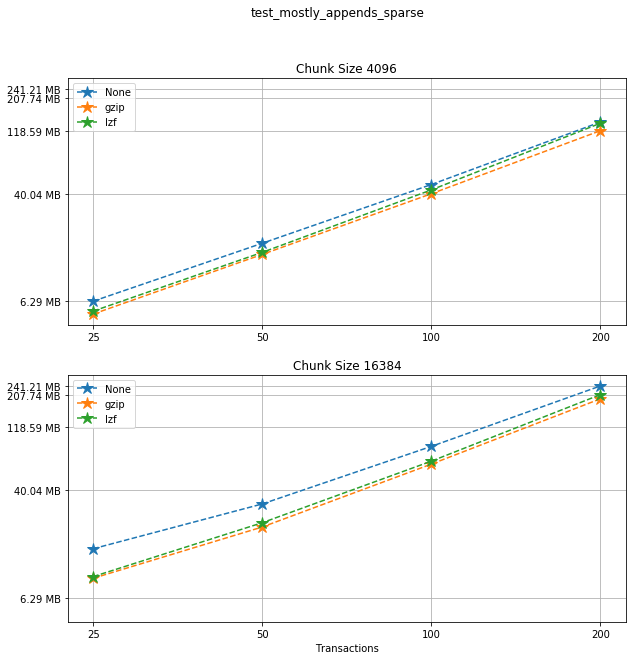

In [54]:
fig, ax = plt.subplots(ncs, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[j].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=f"{compression[start]}")
        ax[j].legend(loc='upper left')
        ax[j].set_title(f"Chunk Size {chunk_sizes[start+j*n]}")
        ax[j].set_xticks(num_transactions[:n])
        ax[j].set_xticklabels(num_transactions[:n])
        ax[j].set_yticks(filesizes[selected])
        ax[j].set_yticklabels(sizelabels[selected])
        ax[j].grid(True)
        ax[j].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

### Comparing chunk sizes

Now, for each choice of compression algorithm, we compare different chunk sizes.

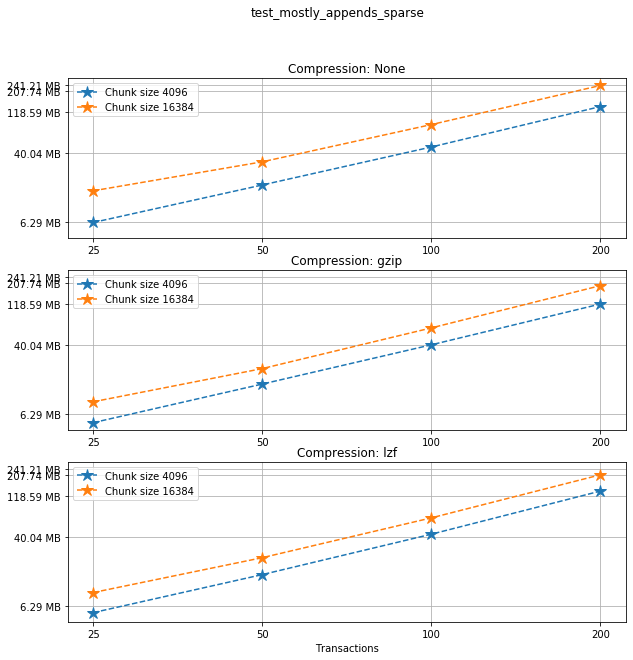

In [55]:
fig, ax = plt.subplots(ncomp, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")
    
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plotlabel = f"Chunk size {chunk_sizes[start+j*n]}"
        plottitle = f"Compression: {compression[start]}"
        ax[i].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=plotlabel)
        ax[i].legend(loc='upper left')
        ax[i].set_title(plottitle)
        ax[i].set_xticks(num_transactions[:n])
        ax[i].set_xticklabels(num_transactions[:n])
        ax[i].set_yticks(filesizes[selected])
        ax[i].set_yticklabels(sizelabels[selected])
        ax[i].grid(True)
        ax[i].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

## Creation times

The creation times for each file are as follows.

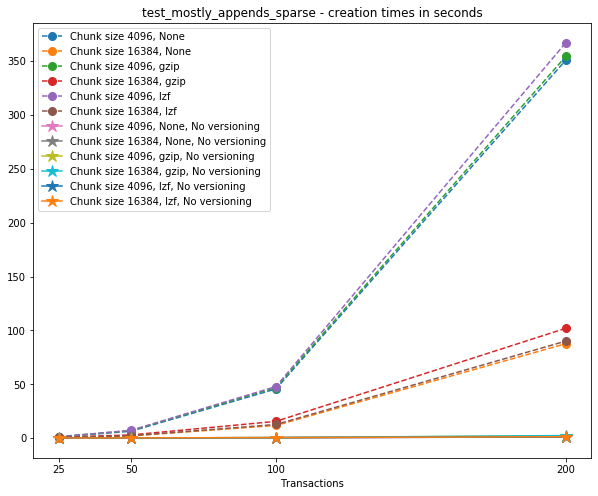

In [56]:
t_write = np.array([test['t_write'][-1] for test in testcase_2])
fig_large_fraction_changes_times = plt.figure(figsize=(10,8))
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write[start+j*n:start+(j+1)*n], 
                 'o--', ms=8, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")

# If you also with to plot information about the "no versions" test,  
# run the following lines:
t_write_nv = np.array([test['t_write'][-1] for test in testcase_2_no_versions])
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write_nv[start+j*n:start+(j+1)*n], 
                 '*-', ms=12, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}, No versioning")

plt.xlabel("Transactions")
plt.title(f"{testname} - creation times in seconds")
plt.legend()
plt.xticks(num_transactions[:n])
plt.show()

Again, the graphs below show, for each fixed number of transactions, the time required to add new versions as the file is created.

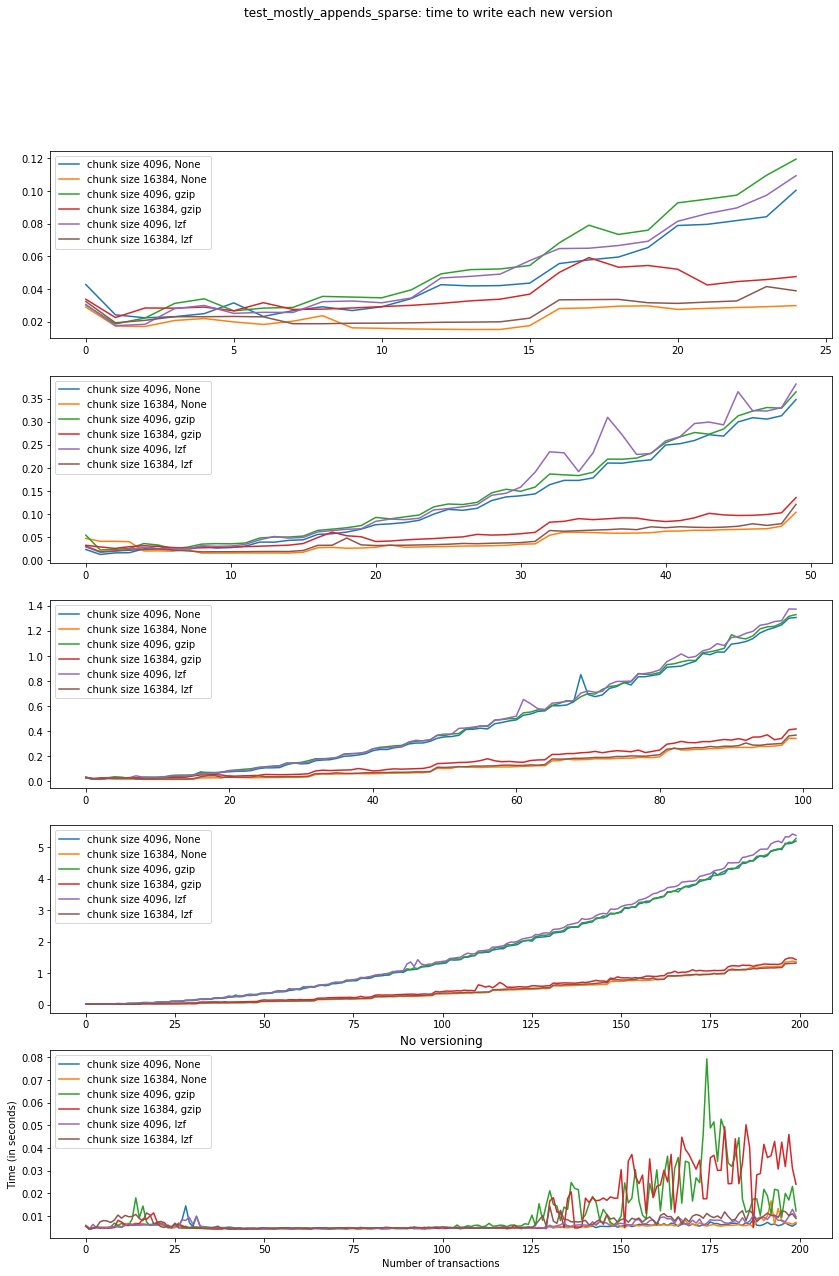

In [57]:
fig_times, ax = plt.subplots(n+1, figsize=(14,20))
fig_times.suptitle(f"{testname}: time to write each new version")

for i in range(n):
    for test in testcase_2:
        if test['num_transactions'] == num_transactions[i]:
            t_write = np.array(test['t_write'][:-1])
            ax[i].plot(t_write, 
                       label=f"chunk size {test['chunk_size']}, {test['compression']}")
            ax[i].legend(loc='upper left')

# If you also with to plot information about the "no versions" test,  
# run the following lines:
for test in testcase_2_no_versions:
    if test['num_transactions'] == num_transactions[i]:
        t_write = np.array(test['t_write'][:-1])
        ax[n].plot(t_write, 
                   label=f"chunk size {test['chunk_size']}, {test['compression']}")
        ax[n].legend(loc='upper left')
        ax[n].set_title('No versioning')
            
plt.xlabel("Number of transactions")
plt.ylabel("Time (in seconds)")
plt.show()

The result is similar to the first test: smaller chunk sizes correspond to smaller file sizes, but larger creation times. However, in this case, we can see there is a drop in performance when adding new versions as our file grows. This can be seen as an effect of the increase in the data size for each new version (since we are *mostly appending* data with each new version) but **can't be explained by that alone**, as evidenced by the difference in scale between creation sizes for the versioned and non-versioned cases.

[Back to top](#home)

<a id='test3'></a>

# Test 3: Small fraction changes (sparse)

In [ ]:
testname = "test_small_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_3 = [50, 100, 500, 1000, 5000, 10000]
```

### Generating new tests

Change `num_transactions_3`, `exponents_3` and `compression_3` as desired:

In [ ]:
num_transactions_3 = [50, 100, 500]
exponents_3 = [12, 14]
compression_3 = [None, "gzip", "lzf"]

Create files:

In [ ]:
testcase = performance_tests.test_small_fraction_changes_sparse(path=path,
                                                                num_transactions=num_transactions_3, 
                                                                exponents=exponents_3, 
                                                                compression=compression_3)

testcase_3, msg = testcase.create_files()
if msg:
    print(msg)

For later comparison, if you wish to generate the same tests with **no versioning**, meaning no use of the `VersionedHDF5` library, you can use the following command:

In [ ]:
testcase_3_no_versions, msg = testcase.create_files(versions=False)
if msg:
    print(msg)

If you wish to save the results for later, execute the cell below:

In [ ]:
testcase.save(testcase_3, f"{testname}")
testcase.save(testcase_3_no_versions, f"{testname}_no_versions")

### Reading previously computed tests

To read an existing `.json` file, use

In [ ]:
with open(f"{testname}.json", "r") as json_in:
    testcase_3 = json.load(json_in)
with open(f"{testname}_no_versions.json", "r") as json_in:
    testcase_3_no_versions = json.load(json_in)

## Analysis

Again, let's show the size information in a graph:

In [ ]:
num_transactions = [test['num_transactions'] for test in testcase_3]
chunk_sizes = [test['chunk_size'] for test in testcase_3]
compression = [test['compression'] for test in testcase_3]
filesizes = np.array([test['size'] for test in testcase_3])
sizelabels = np.array([test['size_label'] for test in testcase_3])

n = len(set(num_transactions))
ncs = len(set(chunk_sizes))
ncomp = len(set(compression))

Again, on the left we can see a linear plot, and on the right a loglog plot of the same size data for `testcase_3`.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[0].plot(num_transactions[:n],
                   filesizes[start+j*n:start+(j+1)*n], 
                   '*--', ms=12, 
                   label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[1].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n], 
                     '*--', ms=12, 
                     label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')
        ax[0].minorticks_off()
        ax[1].minorticks_off()
        # Changing the indices in selected will change the y-axis ticks in the graph for better visualization
        selected = (range(len(filesizes)))
        ax[0].set_xticks(num_transactions[:n])
        ax[0].set_xticklabels(num_transactions[:n])
        ax[0].set_yticks(filesizes[selected])
        ax[0].set_yticklabels(sizelabels[selected])
        ax[0].set_xlabel("Transactions")
        ax[0].grid(True)
        ax[1].set_xticks(num_transactions[:n])
        ax[1].set_xticklabels(num_transactions[:n])
        ax[1].set_yticks(filesizes[selected])
        ax[1].set_yticklabels(sizelabels[selected])
        ax[1].set_xlabel("Transactions")
        ax[1].grid(True)

plt.suptitle(f"{testname}")
plt.show()

### Comparing compression algorithms

For each chunk size that we chose to test, let's compare the file sizes corresponding to each compression algorithm that we used.

In [ ]:
fig, ax = plt.subplots(ncs, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[j].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=f"{compression[start]}")
        ax[j].legend(loc='upper left')
        ax[j].set_title(f"Chunk Size {chunk_sizes[start+j*n]}")
        ax[j].set_xticks(num_transactions[:n])
        ax[j].set_xticklabels(num_transactions[:n])
        ax[j].set_yticks(filesizes)
        ax[j].set_yticklabels(sizelabels)
        ax[j].grid(True)
        ax[j].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

### Comparing chunk sizes

Now, for each choice of compression algorithm, we compare different chunk sizes.

In [ ]:
fig, ax = plt.subplots(ncomp, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")
    
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plotlabel = f"Chunk size {chunk_sizes[start+j*n]}"
        plottitle = f"Compression: {compression[start]}"
        ax[i].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=plotlabel)
        ax[i].legend(loc='upper left')
        ax[i].set_title(plottitle)
        ax[i].set_xticks(num_transactions[:n])
        ax[i].set_xticklabels(num_transactions[:n])
        ax[i].set_yticks(filesizes)
        ax[i].set_yticklabels(sizelabels)
        ax[i].grid(True)
        ax[i].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

## Creation times

If we look at the creation times for these files, we have something like this:

In [ ]:
t_write = np.array([test['t_write'][-1] for test in testcase_3])
fig_large_fraction_changes_times = plt.figure(figsize=(10,8))
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write[start+j*n:start+(j+1)*n], 
                 'o--', ms=8, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")

# If you also with to plot information about the "no versions" test,  
# run the following lines:
t_write_nv = np.array([test['t_write'][-1] for test in testcase_3_no_versions])
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write_nv[start+j*n:start+(j+1)*n], 
                 '*-', ms=12, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}, No versioning")

plt.xlabel("Transactions")
plt.title(f"{testname} - creation times in seconds")
plt.legend()
plt.xticks(num_transactions[:n])
plt.show()

Again, the graphs below show, for each fixed number of transactions, the time required to add new versions as the file is created.

In [ ]:
fig_times, ax = plt.subplots(n+1, figsize=(14,20))
fig_times.suptitle(f"{testname}: time to write each new version")

for i in range(n):
    for test in testcase_3:
        if test['num_transactions'] == num_transactions[i]:
            t_write = np.array(test['t_write'][:-1])
            ax[i].plot(t_write, 
                       label=f"chunk size {test['chunk_size']}, {test['compression']}")
            ax[i].legend(loc='upper left')

# If you also with to plot information about the "no versions" test,  
# run the following lines:
for test in testcase_3_no_versions:
    if test['num_transactions'] == num_transactions[i]:
        t_write = np.array(test['t_write'][:-1])
        ax[n].plot(t_write, 
                   label=f"chunk size {test['chunk_size']}, {test['compression']}")
        ax[n].legend(loc='upper left')
        ax[n].set_title('No versioning')
            
plt.xlabel("Number of transactions")
plt.ylabel("Time (in seconds)")
plt.show()

This behaviour is similar to what we got in the `test_large_fraction_changes_sparse` case, but with larger transaction numbers there is a slight increase in the time required to write new versions as the file size grows.

[Back to top](#home)

<a id='test4'></a>

# Test 4: Mostly appends (dense)

In [58]:
testname = "test_mostly_appends_dense"

For this case, we have tested the following number of transactions:

```python
num_transactions_4 = [50, 100, 200]
```

Change `num_transactions_4`, `exponents_4` and `compression_4` as desired:

In [59]:
num_transactions_4 = [25, 50, 100, 200]
exponents_4 = [12, 14]
compression_4 = [None, "gzip", "lzf"]

In [ ]:
testcase = performance_tests.test_mostly_appends_dense(path=path,
                                                       num_transactions=num_transactions_4, 
                                                       exponents=exponents_4, 
                                                       compression=compression_4)

testcase_4, msg = testcase.create_files()
if msg:
    print(msg)

For later comparison, if you wish to generate the same tests with **no versioning**, meaning no use of the `VersionedHDF5` library, you can use the following command:

In [ ]:
testcase_4_no_versions, msg = testcase.create_files(versions=False)
if msg:
    print(msg)

If you wish to save the results for later, execute the cell below:

In [ ]:
testcase.save(testcase_4, f"{testname}")
testcase.save(testcase_4_no_versions, f"{testname}_no_versions")

### Reading previously computed tests

To open an existing `.json` file, use

In [61]:
with open(f"{testname}.json", "r") as json_in:
    testcase_4 = json.load(json_in)
with open(f"{testname}_no_versions.json", "r") as json_in:
    testcase_4_no_versions = json.load(json_in)

## Analysis

Let's show the size information in a graph:

In [62]:
num_transactions = [test['num_transactions'] for test in testcase_4]
chunk_sizes = [test['chunk_size'] for test in testcase_4]
compression = [test['compression'] for test in testcase_4]
filesizes = np.array([test['size'] for test in testcase_4])
sizelabels = np.array([test['size_label'] for test in testcase_4])

n = len(set(num_transactions))
ncs = len(set(chunk_sizes))
ncomp = len(set(compression))

Once more, on the left we can see a linear plot, and on the right a loglog plot of the same size data for `testcase_4`.

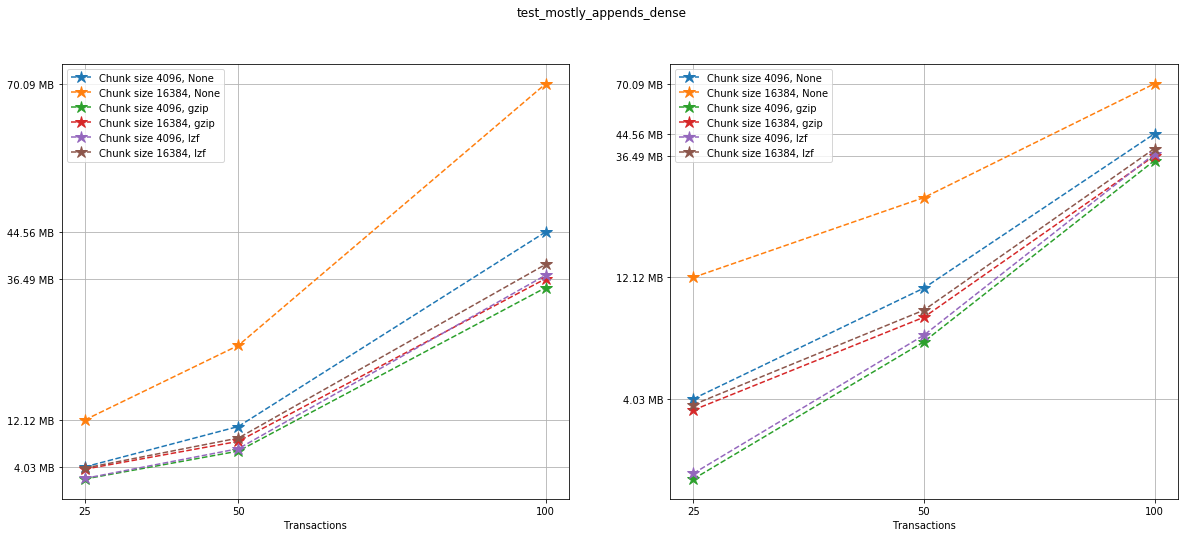

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

selected = [0, 2, 3, 5, 11]

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[0].plot(num_transactions[:n],
                   filesizes[start+j*n:start+(j+1)*n], 
                   '*--', ms=12, 
                   label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[1].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n], 
                     '*--', ms=12, 
                     label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')
        ax[0].minorticks_off()
        ax[1].minorticks_off()
        # Changing the indices in selected will change the y-axis ticks in the graph for better visualization
        ax[0].set_xticks(num_transactions[:n])
        ax[0].set_xticklabels(num_transactions[:n])
        ax[0].set_yticks(filesizes[selected])
        ax[0].set_yticklabels(sizelabels[selected])
        ax[0].set_xlabel("Transactions")
        ax[0].grid(True)
        ax[1].set_xticks(num_transactions[:n])
        ax[1].set_xticklabels(num_transactions[:n])
        ax[1].set_yticks(filesizes[selected])
        ax[1].set_yticklabels(sizelabels[selected])
        ax[1].set_xlabel("Transactions")
        ax[1].grid(True)

plt.suptitle(f"{testname}")
plt.show()

### Comparing compression algorithms

For each chunk size that we chose to test, let's compare the file sizes corresponding to each compression algorithm that we used.

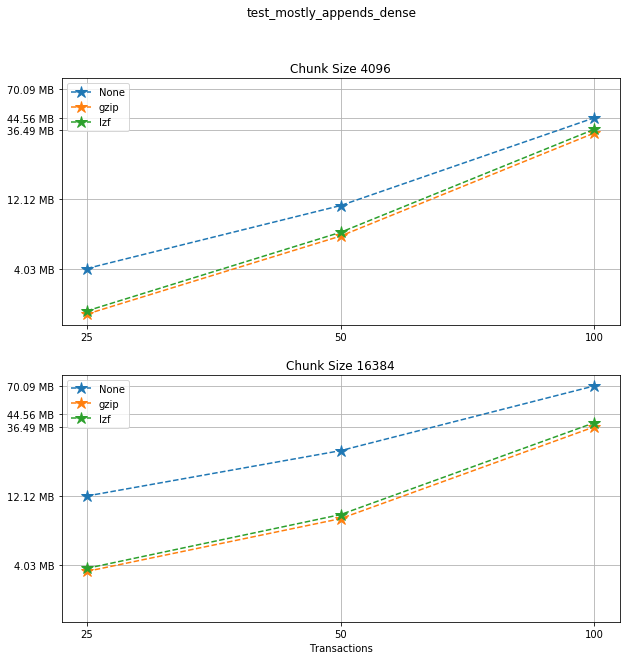

In [78]:
fig, ax = plt.subplots(ncs, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[j].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=f"{compression[start]}")
        ax[j].legend(loc='upper left')
        ax[j].set_title(f"Chunk Size {chunk_sizes[start+j*n]}")
        ax[j].set_xticks(num_transactions[:n])
        ax[j].set_xticklabels(num_transactions[:n])
        ax[j].set_yticks(filesizes[selected])
        ax[j].set_yticklabels(sizelabels[selected])
        ax[j].grid(True)
        ax[j].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

### Comparing chunk sizes

Now, for each choice of compression algorithm, we compare different chunk sizes.

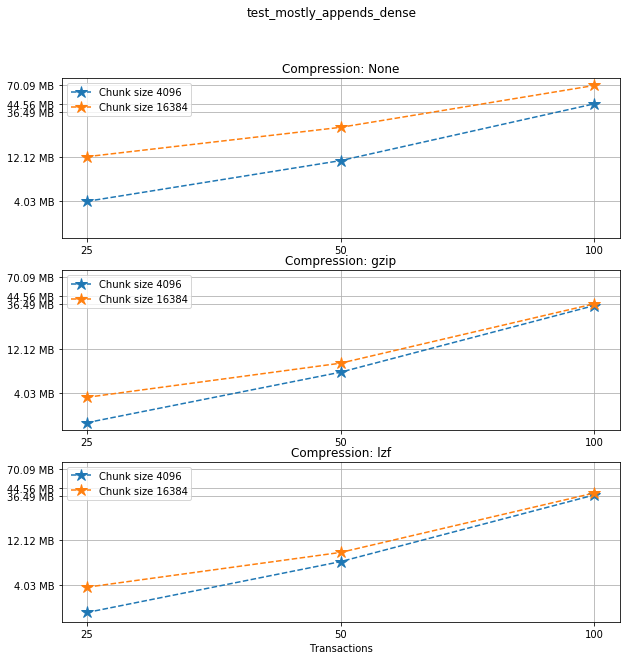

In [79]:
fig, ax = plt.subplots(ncomp, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")
    
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plotlabel = f"Chunk size {chunk_sizes[start+j*n]}"
        plottitle = f"Compression: {compression[start]}"
        ax[i].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=plotlabel)
        ax[i].legend(loc='upper left')
        ax[i].set_title(plottitle)
        ax[i].set_xticks(num_transactions[:n])
        ax[i].set_xticklabels(num_transactions[:n])
        ax[i].set_yticks(filesizes[selected])
        ax[i].set_yticklabels(sizelabels[selected])
        ax[i].grid(True)
        ax[i].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

## Creation times

If we look at the creation times for these files, we have something like this:

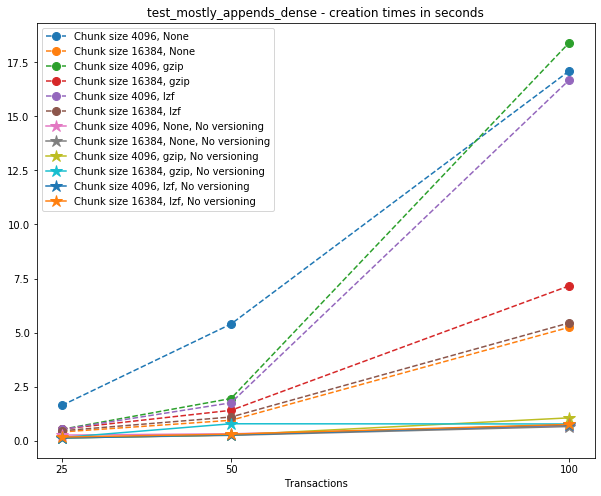

In [80]:
t_write = np.array([test['t_write'][-1] for test in testcase_4])
fig_large_fraction_changes_times = plt.figure(figsize=(10,8))
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write[start+j*n:start+(j+1)*n], 
                 'o--', ms=8, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")

# If you also with to plot information about the "no versions" test,  
# run the following lines:
t_write_nv = np.array([test['t_write'][-1] for test in testcase_4_no_versions])
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write_nv[start+j*n:start+(j+1)*n], 
                 '*-', ms=12, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}, No versioning")

plt.xlabel("Transactions")
plt.title(f"{testname} - creation times in seconds")
plt.legend()
plt.xticks(num_transactions[:n])
plt.show()

Again, the graphs below show, for each fixed number of transactions, the time required to add new versions as the file is created.

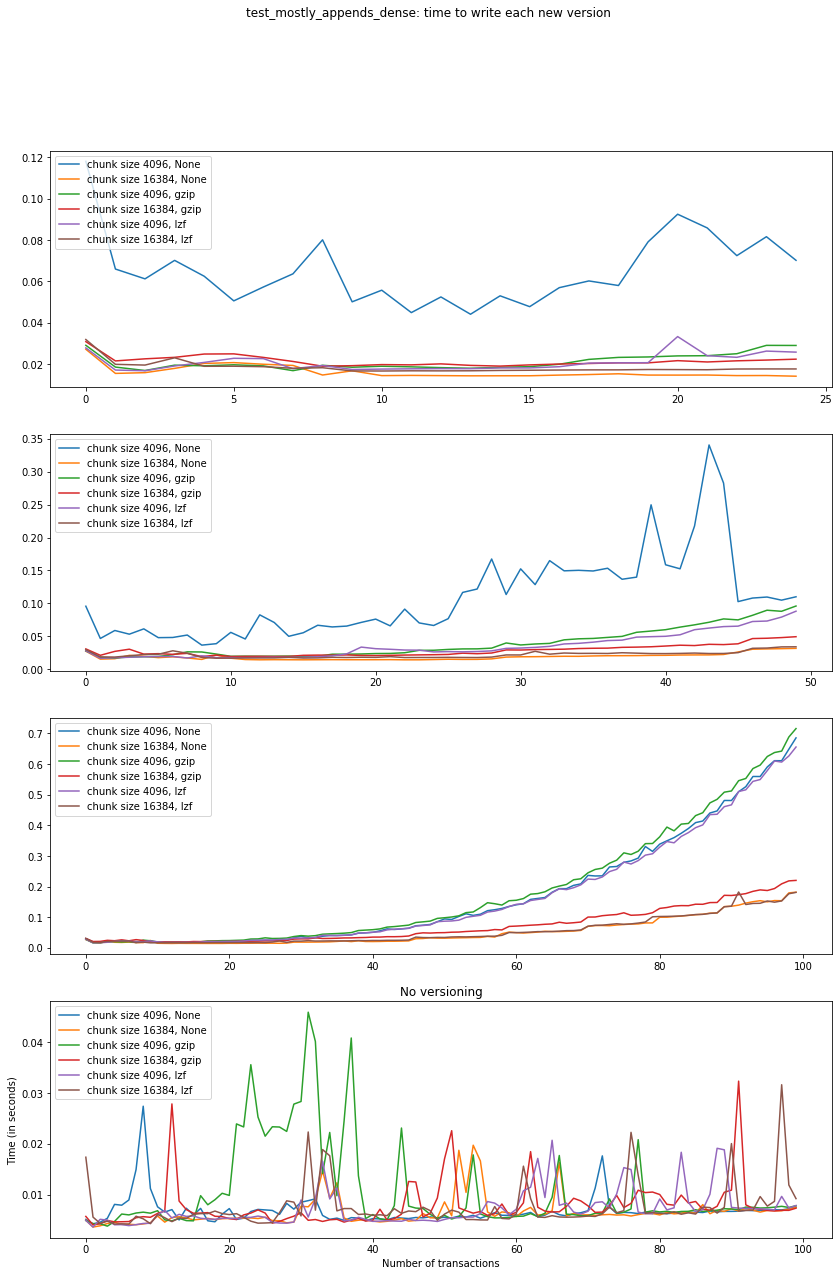

In [81]:
fig_times, ax = plt.subplots(n+1, figsize=(14,20))
fig_times.suptitle(f"{testname}: time to write each new version")

for i in range(n):
    for test in testcase_4:
        if test['num_transactions'] == num_transactions[i]:
            t_write = np.array(test['t_write'][:-1])
            ax[i].plot(t_write, 
                       label=f"chunk size {test['chunk_size']}, {test['compression']}")
            ax[i].legend(loc='upper left')

# If you also with to plot information about the "no versions" test,  
# run the following lines:
for test in testcase_4_no_versions:
    if test['num_transactions'] == num_transactions[i]:
        t_write = np.array(test['t_write'][:-1])
        ax[n].plot(t_write, 
                   label=f"chunk size {test['chunk_size']}, {test['compression']}")
        ax[n].legend(loc='upper left')
        ax[n].set_title('No versioning')
            
plt.xlabel("Number of transactions")
plt.ylabel("Time (in seconds)")
plt.show()

The behaviour is similar to what we observed in `mostly_appends_sparse`.

[Back to top](#home)

<a id='test5'></a>

# Test 5: Large fraction changes - constant array size (sparse)

In [82]:
testname = "test_large_fraction_constant_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_5 = [50, 100, 500, 1000, 5000, 10000]
```

### Generating new tests

Change `num_transactions_5`, `exponents_5` and `compression_5` as desired:

In [ ]:
num_transactions_5 = [50, 100, 500]
exponents_5 = [12, 14]
compression_5 = [None, "gzip", "lzf"]

Create files:

In [ ]:
testcase = performance_tests.test_large_fraction_constant_sparse(path=path,
                                                                 num_transactions=num_transactions_5, 
                                                                 exponents=exponents_5, 
                                                                 compression=compression_5)

testcase_5, msg = testcase.create_files()
if msg:
    print(msg)

For later comparison, if you wish to generate the same tests with **no versioning**, meaning no use of the `VersionedHDF5` library, you can use the following command:

In [ ]:
testcase_5_no_versions, msg = testcase.create_files(versions=False)
if msg:
    print(msg)

If you wish to save the results for later, execute the cell below:

In [ ]:
testcase.save(testcase_5, f"{testname}")
testcase.save(testcase_5_no_versions, f"{testname}_no_versions")

### Reading previously computed tests

To read an existing `.json` file, use

In [83]:
with open(f"{testname}.json", "r") as json_in:
    testcase_5 = json.load(json_in)
with open(f"{testname}_no_versions.json", "r") as json_in:
    testcase_5_no_versions = json.load(json_in)

## Analysis

Again, let's show the size information in a graph:

In [84]:
num_transactions = [test['num_transactions'] for test in testcase_5]
chunk_sizes = [test['chunk_size'] for test in testcase_5]
compression = [test['compression'] for test in testcase_5]
filesizes = np.array([test['size'] for test in testcase_5])
sizelabels = np.array([test['size_label'] for test in testcase_5])

n = len(set(num_transactions))
ncs = len(set(chunk_sizes))
ncomp = len(set(compression))

Again, on the left we can see a linear plot, and on the right a loglog plot of the same size data for `testcase_3`.

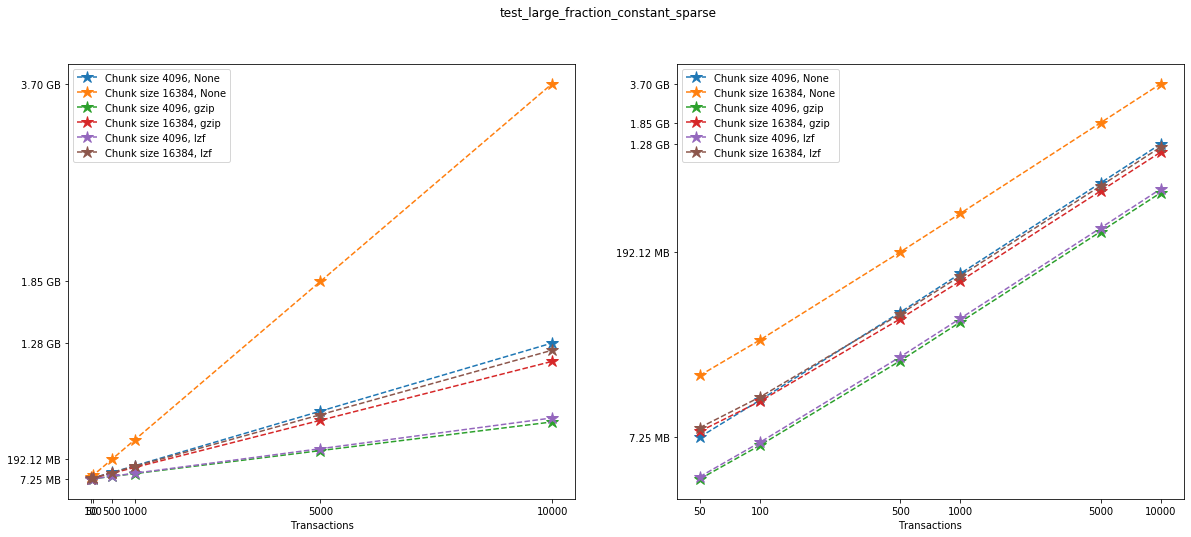

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

selected = [0, 5, 8, 10, 11]

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[0].plot(num_transactions[:n],
                   filesizes[start+j*n:start+(j+1)*n], 
                   '*--', ms=12, 
                   label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[1].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n], 
                     '*--', ms=12, 
                     label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')
        ax[0].minorticks_off()
        ax[1].minorticks_off()
        # Changing the indices in selected will change the y-axis ticks in the graph for better visualization
        ax[0].set_xticks(num_transactions[:n])
        ax[0].set_xticklabels(num_transactions[:n])
        ax[0].set_yticks(filesizes[selected])
        ax[0].set_yticklabels(sizelabels[selected])
        ax[0].set_xlabel("Transactions")
        ax[0].grid(False)
        ax[1].set_xticks(num_transactions[:n])
        ax[1].set_xticklabels(num_transactions[:n])
        ax[1].set_yticks(filesizes[selected])
        ax[1].set_yticklabels(sizelabels[selected])
        ax[1].set_xlabel("Transactions")
        ax[1].grid(False)

plt.suptitle(f"{testname}")
plt.show()

### Comparing compression algorithms

For each chunk size that we chose to test, let's compare the file sizes corresponding to each compression algorithm that we used.

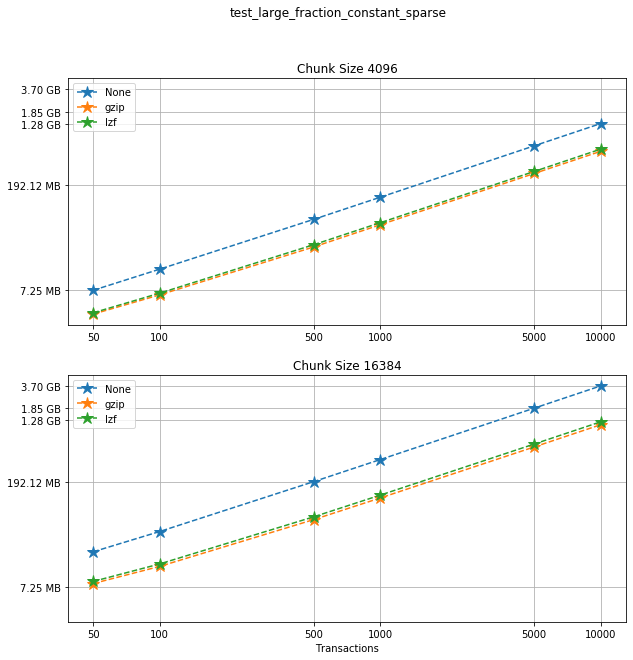

In [98]:
fig, ax = plt.subplots(ncs, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")

for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        ax[j].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=f"{compression[start]}")
        ax[j].legend(loc='upper left')
        ax[j].set_title(f"Chunk Size {chunk_sizes[start+j*n]}")
        ax[j].set_xticks(num_transactions[:n])
        ax[j].set_xticklabels(num_transactions[:n])
        ax[j].set_yticks(filesizes[selected])
        ax[j].set_yticklabels(sizelabels[selected])
        ax[j].grid(True)
        ax[j].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

### Comparing chunk sizes

Now, for each choice of compression algorithm, we compare different chunk sizes.

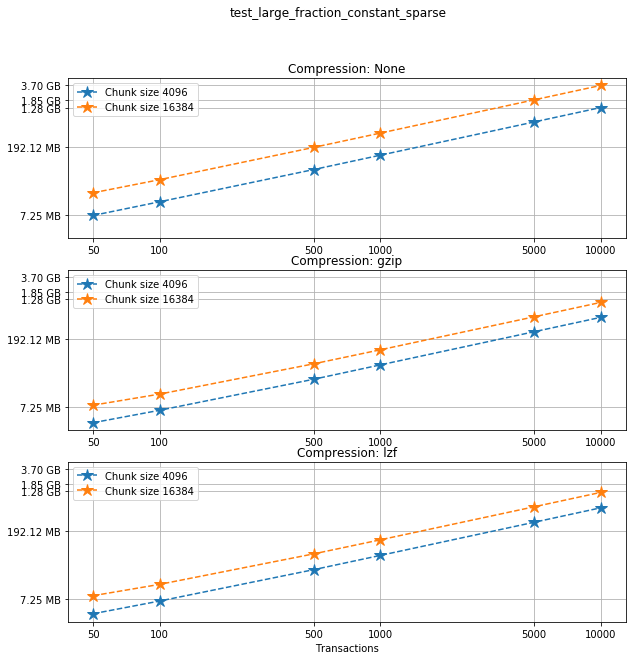

In [99]:
fig, ax = plt.subplots(ncomp, figsize=(10,10), sharey=True)
fig.suptitle(f"{testname}: File sizes")
    
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plotlabel = f"Chunk size {chunk_sizes[start+j*n]}"
        plottitle = f"Compression: {compression[start]}"
        ax[i].loglog(num_transactions[:n],
                     filesizes[start+j*n:start+(j+1)*n],
                     '*--', ms=12, 
                     label=plotlabel)
        ax[i].legend(loc='upper left')
        ax[i].set_title(plottitle)
        ax[i].set_xticks(num_transactions[:n])
        ax[i].set_xticklabels(num_transactions[:n])
        ax[i].set_yticks(filesizes[selected])
        ax[i].set_yticklabels(sizelabels[selected])
        ax[i].grid(True)
        ax[i].minorticks_off()

plt.xlabel("Transactions")
plt.suptitle(f"{testname}")
plt.show()

## Creation times

If we look at the creation times for these files, we have something like this:

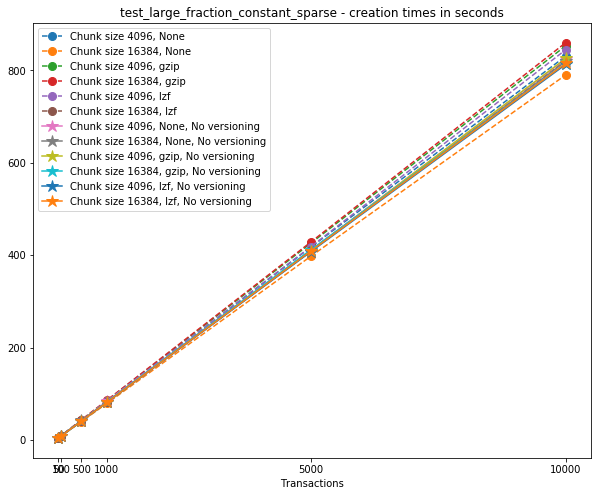

In [100]:
t_write = np.array([test['t_write'][-1] for test in testcase_5])
fig_large_fraction_changes_times = plt.figure(figsize=(10,8))
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write[start+j*n:start+(j+1)*n], 
                 'o--', ms=8, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}")

# If you also with to plot information about the "no versions" test,  
# run the following lines:
t_write_nv = np.array([test['t_write'][-1] for test in testcase_5_no_versions])
for i in range(ncomp):
    start = i*ncs*n
    for j in range(ncs):
        plt.plot(num_transactions[:n], 
                 t_write_nv[start+j*n:start+(j+1)*n], 
                 '*-', ms=12, 
                 label=f"Chunk size {chunk_sizes[start+j*n]}, {compression[start]}, No versioning")

plt.xlabel("Transactions")
plt.title(f"{testname} - creation times in seconds")
plt.legend()
plt.xticks(num_transactions[:n])
plt.show()

Again, the graphs below show, for each fixed number of transactions, the time required to add new versions as the file is created.

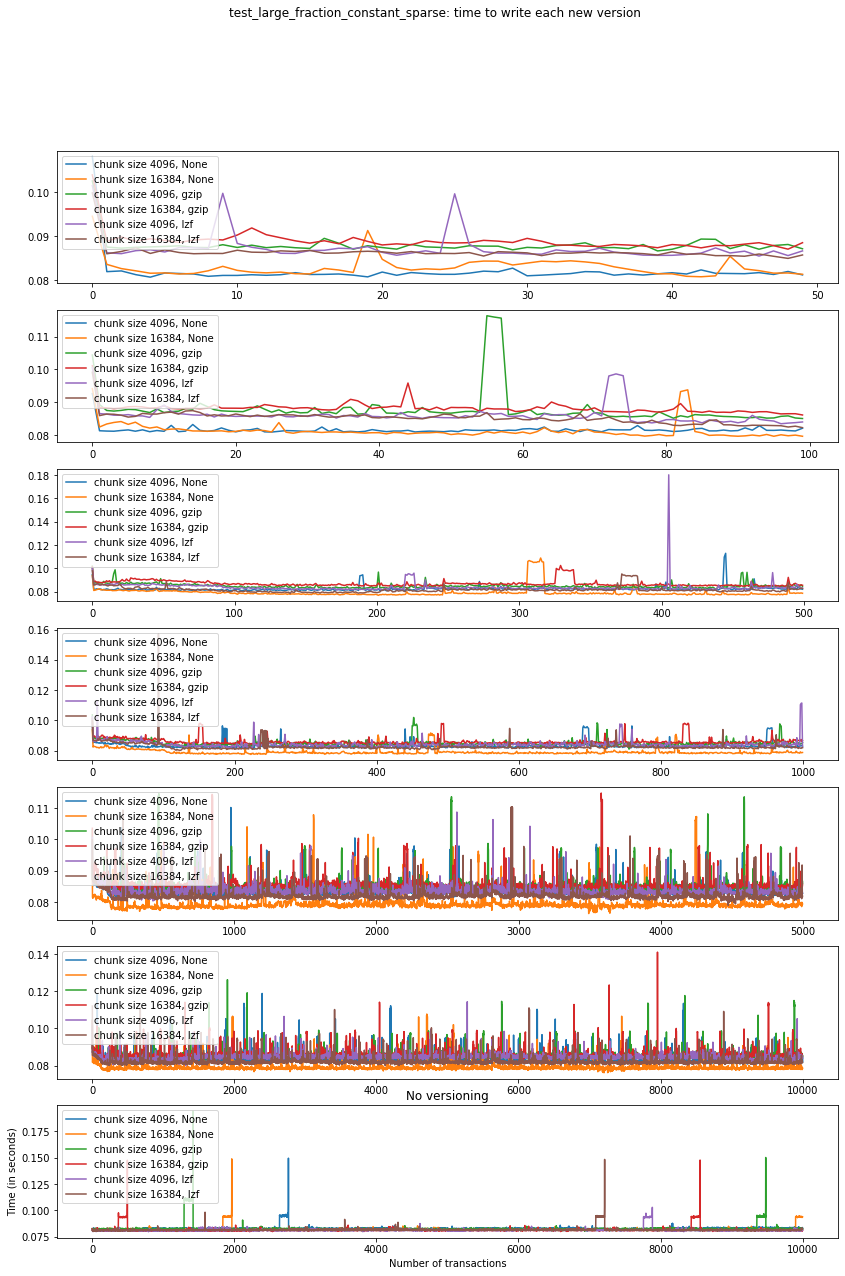

In [101]:
fig_times, ax = plt.subplots(n+1, figsize=(14,20))
fig_times.suptitle(f"{testname}: time to write each new version")

for i in range(n):
    for test in testcase_5:
        if test['num_transactions'] == num_transactions[i]:
            t_write = np.array(test['t_write'][:-1])
            ax[i].plot(t_write, 
                       label=f"chunk size {test['chunk_size']}, {test['compression']}")
            ax[i].legend(loc='upper left')

# If you also with to plot information about the "no versions" test,  
# run the following lines:
for test in testcase_5_no_versions:
    if test['num_transactions'] == num_transactions[i]:
        t_write = np.array(test['t_write'][:-1])
        ax[n].plot(t_write, 
                   label=f"chunk size {test['chunk_size']}, {test['compression']}")
        ax[n].legend(loc='upper left')
        ax[n].set_title('No versioning')
            
plt.xlabel("Number of transactions")
plt.ylabel("Time (in seconds)")
plt.show()

This behaviour is unique to this case; here we can see the creation times do not vary as much between the versioned and non-versioned case.

[Back to top](#home)

## Understanding each file

Each versioned HDF5 file contains 3 datasets per version:
- `key0`, an array of `int64`
- `key1`, an array of `int64`
- `val`, an array of `float64`
plus metadata about groups, datasets and versions.

This means that each file has  

```
nversions * 24 * arraysize + metadata
```
bytes of information.

<a id='standard'></a>
## Standard parameters

- `test_large_fraction_changes_sparse`: 
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 1000`
- `test_small_fraction_changes_sparse`
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 10`
- `test_mostly_appends_sparse`:
    - `num_rows_initial = 1000`
    - `num_rows_per_append = 1000`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 10`  
- `test_mostly_appends_dense`
    - `num_rows_initial_0 = 30`
    - `num_rows_initial_1 = 30`
    - `num_rows_per_append_0 = 1`
    - `num_inserts_0 = 1`
    - `num_inserts_1 = 10`
    - `num_deletes_0 = 1`
    - `num_deletes_1 = 1`
    - `num_changes = 10`